# Figure 03: Hysteretic bahaviour

In this notebook, hysteretic behaviour shown in Figure 3 in [Beg *et al.* Stable and manipulable Bloch point. *Scientific Reports*, **9**, 7959 (2019)](https://doi.org/10.1038/s41598-019-44462-2) is simulated:

<img src="hysteresis.png" width=800>

We need to simulate hysteretic behaviour of a $150 \,\text{nm}$ disk, which consists of two layers with different sign of Dzyaloshinskii-Moriya constant $D$. The bottom layer with $D<0$ has $20 \,\text{nm}$ thickness, whereas the top layer with $D>0$ has $10 \,\text{nm}$ thickness. We start by importing the necessary modules and creating the mesh with two regions.

First we start by setting up the system object.

In [1]:
import oommfc as oc
import discretisedfield as df
%matplotlib inline

d = 150e-9
hb = 20e-9
ht = 10e-9
cell = (5e-9, 5e-9, 2.5e-9)
n = (31, 31, 5)
regions = {'r1': df.Region(p1=(-d/2, -d/2, -hb), p2=(d/2, d/2, 0)),
           'r2': df.Region(p1=(-d/2, -d/2, 0), p2=(d/2, d/2, ht))}
p1 = (-d/2, -d/2, -hb)
p2 = (d/2, d/2, ht)
mesh = oc.Mesh(p1=p1, p2=p2, n=n, regions=regions)

D = {'r1': 1.58e-3, 'r2': -1.58e-3, 'r1:r2': 1.58e-9}
Ms = 3.84e5
A = 8.78e-12

def Ms_fun(pos):
    x, y, z = pos
    if x**2 + y**2 <= (d/2)**2:
        return Ms
    else:
        return 0

system = oc.System(name='bloch-point')
system.hamiltonian = oc.Exchange(A=A) + oc.DMI(D=D, crystalclass='T') + oc.Demag()
system.m = df.Field(mesh, dim=3, value=(0, 0, 1), norm=Ms_fun)

We start our hysteresis simulations with $1\,\text{T}$ external magnetic field, which saturates the sample magnetisation in the $+z$ direction. By reducing the external magnetic field in steps of $0.1\,\text{T}$, we reach $\mu_{0}H = 0$ and save the equilibrium magnetisation vector field as m1. We see that bottom and top layers relax in vortex-like magnetisation configurations with the same handedness, but with $+z$ and $−z$ polarisations, respectively. This results in a head-to-head Bloch point as we observed in the previous section. Now, we keep reducing the external magnetic field and when we reach $−1\,\text{T}$, the sample is again fully saturated, but this time in the $−z$ direction. Starting from this magnetisation state, we increase the field in same steps until we reach $\mu_{0}H = 0$, and save the magnetisation field as m2. Bottom and top layers are now hosting vortex-like states with the same handedness, but now with $−z$ and $+z$ polarisations, respectively. Therefore, a tail-to-tail Bloch point configuration is formed. Finally, we keep increasing an external magnetic field until we reach the $1\,\text{T}$ value from which we started the hysteresis loop simulation.

In [2]:
import numpy as np

# Create an array of external fields for which the system is relaxed.
Bmax = 1  # maximum field in hysteresis (T)
dB = 0.1  # field step (T)
B_array = np.concatenate([np.arange(Bmax, -Bmax, -dB),
                          np.arange(-Bmax, Bmax+1e-12, dB)])

md = oc.MinDriver()
system.hamiltonian += oc.Zeeman(H=(0, 0, 0))
system.m = df.Field(mesh, dim=3, value=(0, 0, 1), norm=Ms_fun)
mz = []
c = 1
for B in B_array:
    system.hamiltonian.zeeman.H = (0, 0, B/oc.consts.mu0)
    md.drive(system, overwrite=True)
    if abs(B) < 1e-3:
        system.m.write(f'm{c}.omf')
        c += 1
    mz.append(system.m.average[2])

2019/11/28 16:21: Running OOMMF (bloch-point.mif) ... (1.0 s)
2019/11/28 16:21: Running OOMMF (bloch-point.mif) ... (1.0 s)
2019/11/28 16:21: Running OOMMF (bloch-point.mif) ... (1.0 s)
2019/11/28 16:21: Running OOMMF (bloch-point.mif) ... (1.0 s)
2019/11/28 16:21: Running OOMMF (bloch-point.mif) ... (1.1 s)
2019/11/28 16:21: Running OOMMF (bloch-point.mif) ... (1.1 s)
2019/11/28 16:21: Running OOMMF (bloch-point.mif) ... (1.2 s)
2019/11/28 16:21: Running OOMMF (bloch-point.mif) ... (1.0 s)
2019/11/28 16:21: Running OOMMF (bloch-point.mif) ... (1.3 s)
2019/11/28 16:21: Running OOMMF (bloch-point.mif) ... (1.2 s)
2019/11/28 16:21: Running OOMMF (bloch-point.mif) ... (1.0 s)
2019/11/28 16:21: Running OOMMF (bloch-point.mif) ... (1.1 s)
2019/11/28 16:21: Running OOMMF (bloch-point.mif) ... (1.0 s)
2019/11/28 16:21: Running OOMMF (bloch-point.mif) ... (1.1 s)
2019/11/28 16:21: Running OOMMF (bloch-point.mif) ... (1.1 s)
2019/11/28 16:21: Running OOMMF (bloch-point.mif) ... (1.1 s)
2019/11/

The hysteresis loop is

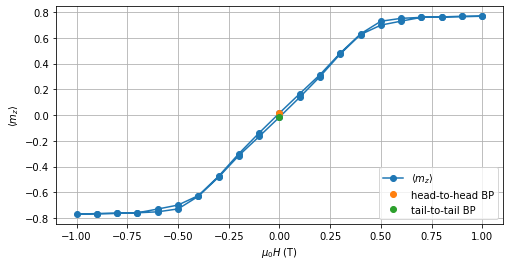

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

mz = np.array(mz)/Ms

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(B_array, mz, 'o-', label=r"$\langle m_{z} \rangle$")
ax.plot(0, mz[10], 'o', label='head-to-head BP')
ax.plot(0, mz[30], 'o', label='tail-to-tail BP')
plt.xlabel(r"$\mu_{0}H$ (T)")
plt.ylabel(r"$\langle m_{z} \rangle$")
plt.legend(loc=4)
plt.grid()

The magnetisation fields in the cross section for $B=0$ are:

In [4]:
m1 = df.Field.fromfile('m1.omf')
m1.plane('y').k3d_vectors(color_field=m1.z, head_size=20)

Output()

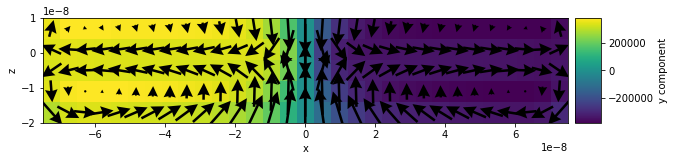

In [5]:
m1.plane('y').mpl(figsize=(10, 5))

In [6]:
m2 = df.Field.fromfile('m2.omf')
m2.plane('y').k3d_vectors(color_field=m2.z, head_size=20)

Output()

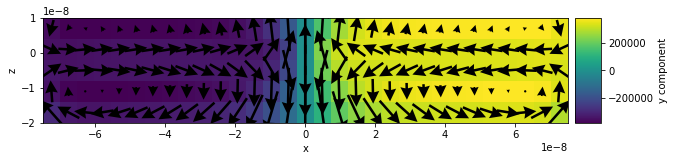

In [7]:
m2.plane('y').mpl(figsize=(10, 5))

## Conclusion

By applying an external magnetic field we found that the system undergoes hysteretic behaviour and two different types of Bloch point configurations exist. In the first, the magnetisation at the centre of each layer points towards the interface - the head-to-head configuration. In the second, the magnetisation points away from the interface towards the outer surface of the disk - the tail-to-tail configuration. We demonstrated the switch between these two different types of Bloch point using an external magnetic field.